In [1]:
# pip install opencv-python tqdm torch torchvision torchaudio numpy pandas matplotlib pillow scikit-learn

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

# Load data

In [3]:
import warnings
warnings.filterwarnings("ignore", category=pd.errors.DtypeWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.simplefilter("ignore", category=NameError)

In [4]:
import os
import cv2

def make_train_data(folder, IMAGE_SIZE=224):
    images = []
    labels = []

    for flower_type in os.listdir(folder):
        img_path = os.path.join(folder, flower_type)

        if os.path.isdir(img_path):
            for image_name in os.listdir(img_path):
                image_path = os.path.join(img_path, image_name)

                try:
                    img = cv2.imread(image_path)
                    img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE),)
                    if img is not None:
                        images.append(np.array(img))
                        labels.append(str(flower_type))
                except Exception as e:
                    print(f'Error reading image: {image_path}, Error: {e}')
                    
    return np.array(images), np.array(labels)

# the name of the folder is labels
images, labels = make_train_data('../data/raw-flowers-data')

In [5]:
images.shape, labels.shape

((4317, 224, 224, 3), (4317,))

In [6]:
temp_imgs = images.copy()
temp_labels =  labels.copy()

flattened_images = temp_imgs.reshape(len(temp_imgs), -1)

# THE DATAFRAME
df = pd.DataFrame(flattened_images, columns=[f"pixel_{i}" for i in range(flattened_images.shape[1])])
df["labels"] = temp_labels

df.head(3)

pixel_0  pixel_1  pixel_2  pixel_3  pixel_4  pixel_5  pixel_6  pixel_7  \
0      134      135      135      139      140      140      145      145   
1      223      216      212      219      213      207      218      211   
2      119      131      136      116      129      132      114      128   

   pixel_8  pixel_9  ...  pixel_150519  pixel_150520  pixel_150521  \
0      145      146  ...           127           128           132   
1      209      227  ...           153           168           176   
2      127      109  ...            86            25            53   

   pixel_150522  pixel_150523  pixel_150524  pixel_150525  pixel_150526  \
0           127           128           132           127           128   
1           161           170           184           155           158   
2            82            20            48            84            21   

   pixel_150527  labels  
0           132   daisy  
1           172   daisy  
2            48   daisy  

[3 rows x 150529 columns]

In [7]:
df["labels"].value_counts()

labels
dandelion    1052
tulip         984
rose          784
daisy         764
sunflower     733
Name: count, dtype: int64

5 classes of flower images, the images have been with [224, 224, 3]

BEFORE SPLITTING AND SHUFFLING THE DATA


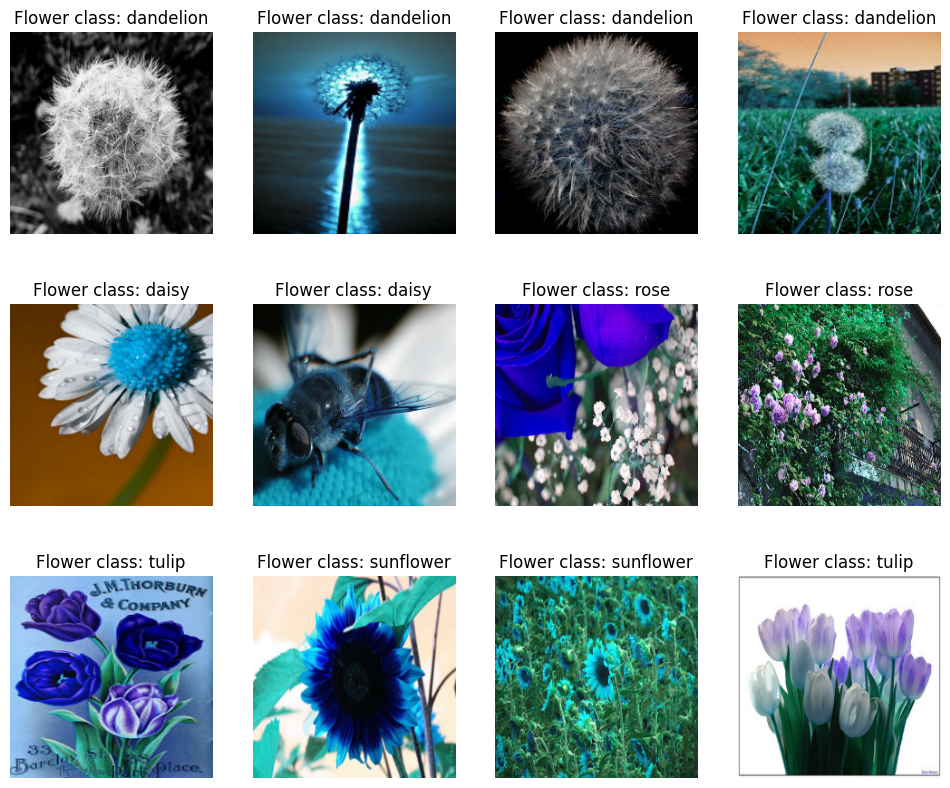

In [8]:
from random import randint
print("BEFORE SPLITTING AND SHUFFLING THE DATA")
plt.figure(figsize=(12, 10))

for i in range(12):
    index = randint(0, len(images))
    plt.subplot(3, 4, i + 1)
    plt.imshow(images[index])
    plt.title(f"Flower class: {labels[index]}")
    plt.axis("off")

plt.show()

## Feture Engineering transformation

##### Encoding text labels

In [9]:
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

labels_df = pd.DataFrame(np.array(labels), columns=["Label"])

le = LabelEncoder()
Y = le.fit_transform(np.array(labels))
Y = to_categorical(Y, 5)
Y_label_encoded = pd.DataFrame(data=Y, columns=le.classes_)
Y_label_encoded["Label"] = labels_df

In [10]:
num_classes = len(le.classes_[0])
flower_classes = le.classes_
print("Classes", flower_classes)
print("Number of classes", num_classes)

Classes ['daisy' 'dandelion' 'rose' 'sunflower' 'tulip']
Number of classes 5


In [11]:
# add the encoded labels to the dataframe
df[Y_label_encoded.columns] = Y_label_encoded

In [12]:
# snippet of the dataframe
df.head(5)

pixel_0  pixel_1  pixel_2  pixel_3  pixel_4  pixel_5  pixel_6  pixel_7  \
0      134      135      135      139      140      140      145      145   
1      223      216      212      219      213      207      218      211   
2      119      131      136      116      129      132      114      128   
3       81       16       26       79       16       26       79       16   
4       31       49       31       31       43       29       27       31   

   pixel_8  pixel_9  ...  pixel_150525  pixel_150526  pixel_150527  labels  \
0      145      146  ...           127           128           132   daisy   
1      209      227  ...           155           158           172   daisy   
2      127      109  ...            84            21            48   daisy   
3       26       79  ...            47            14            25   daisy   
4       23       29  ...            28            38            26   daisy   

   daisy  dandelion  rose  sunflower  tulip  Label  
0    1.0        0.0   0.0        0.0    0.0  daisy  
1    1.0        0.0   0.0        0.0    0.0  daisy  
2    1.0        0.0   0.0        0.0    0.0  daisy  
3    1.0        0.0   0.0        0.0    0.0  daisy  
4    1.0        0.0   0.0        0.0    0.0  daisy  

[5 rows x 150535 columns]

##### Splitting the data 75/25 ratio

In [13]:
images.shape, Y_label_encoded.shape

((4317, 224, 224, 3), (4317, 6))

In [14]:
# Splitting 75% training 15% validation 10% testing
from sklearn.model_selection import train_test_split

train_X, temp_set_X, train_y, temp_set_y = train_test_split(images, Y_label_encoded, test_size=0.25, random_state=42)
valid_X, test_X, valid_y,  test_y = train_test_split(temp_set_X, temp_set_y, test_size=0.4, random_state=42)

In [15]:
print("view compatibility of shapes in terms of number of raws")
print("train_X set shape", train_X.shape)
print("train_y set shape", train_y.shape)

print("valid_X set shape", valid_X.shape)
print("valid_y set shape", valid_y.shape)

print("test_X set shape", test_X.shape)
print("test_y set shape", test_y.shape)

view compatibility of shapes in terms of number of raws
train_X set shape (3237, 224, 224, 3)
train_y set shape (3237, 6)
valid_X set shape (648, 224, 224, 3)
valid_y set shape (648, 6)
test_X set shape (432, 224, 224, 3)
test_y set shape (432, 6)


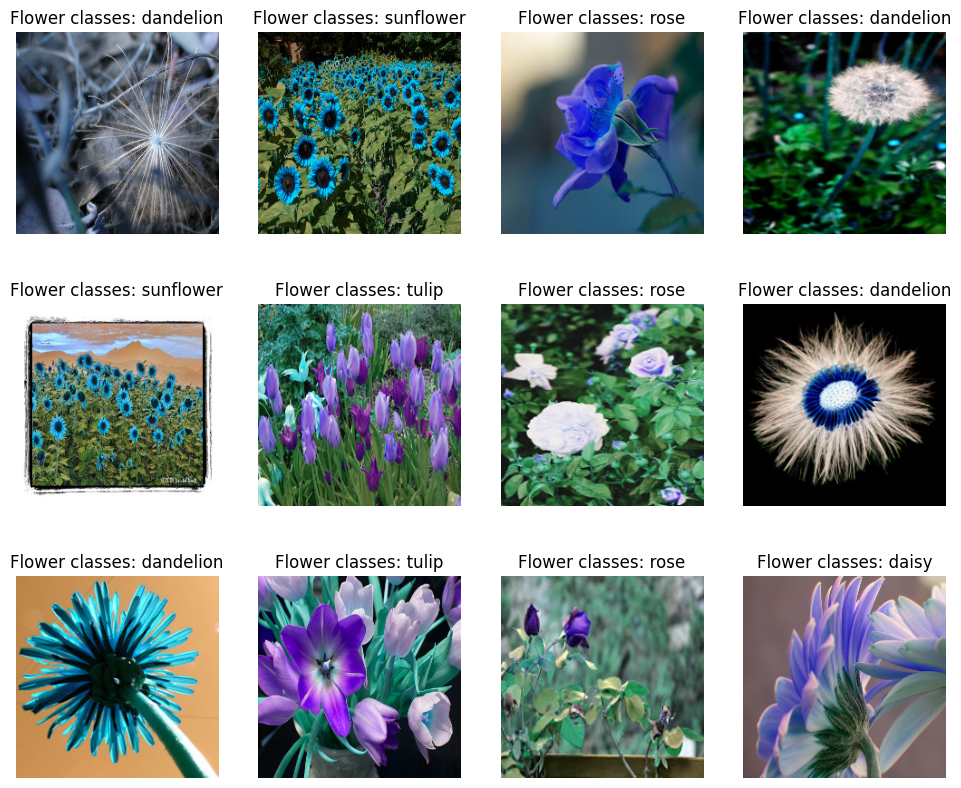

In [16]:
# After splitting and shuffling
plt.figure(figsize=(12, 10))
for index in range(12):
    plt.subplot(3, 4, index + 1)
    plt.imshow(train_X[index])
    plt.title(f"Flower classes: {train_y["Label"].iloc[index]}")
    plt.axis("off")

plt.show()

##### Image preprocessing layers
In tensor flow based transfer learning. Preprocessing the data which includes resizing, rescaling and center cropping. We utilize a pretrained model's process input function. provided by keras library

In [17]:
# A layer to process the image inputs resizig and scaling
preprocess = tf.keras.Sequential([
    tf.keras.layers.Resizing(height=224, width=224, crop_to_aspect_ratio=True), # Changing the images size
    tf.keras.layers.Lambda(tf.keras.applications.resnet_v2.preprocess_input)  # Scaling the input t0 -1 to 1
])

In [18]:
train_X = preprocess(train_X)
valid_X = preprocess(valid_X)
test_X = preprocess(test_X)

In [19]:
test_X.shape, test_y.shape

(TensorShape([432, 224, 224, 3]), (432, 6))

The dataset is not images of 224x224px with values ranging from -1 to 1

In [20]:
# drop the Label column model does not accept text input
train_set_y_le = train_y.drop(columns=["Label"], axis=1)
valid_set_y_le = valid_y.drop(columns=["Label"], axis=1)
test_set_y_le = test_y.drop(columns=["Label"], axis=1)

In [21]:
train_set_y_le.head(2)

daisy  dandelion  rose  sunflower  tulip
816     0.0        1.0   0.0        0.0    0.0
3317    0.0        0.0   0.0        1.0    0.0

In [22]:
train_set_y_le.shape

(3237, 5)

#### data augmentation
To randomly increase size, varrying contrst, flipping, and random rotation of training set. Necessary, to minimize overfitting
Using keras data augmentation layers

In [23]:

# a Sequential layer to perform data augmentation rotation, flip and contrast
augmented_d = tf.keras.Sequential([
    tf.keras.layers.RandomRotation(factor=0.025, seed=42),
    tf.keras.layers.RandomFlip(mode="horizontal", seed=42),
     tf.keras.layers.RandomContrast(factor=0.2, seed=42)
])
X_train_aug = augmented_d(train_X, training=True)

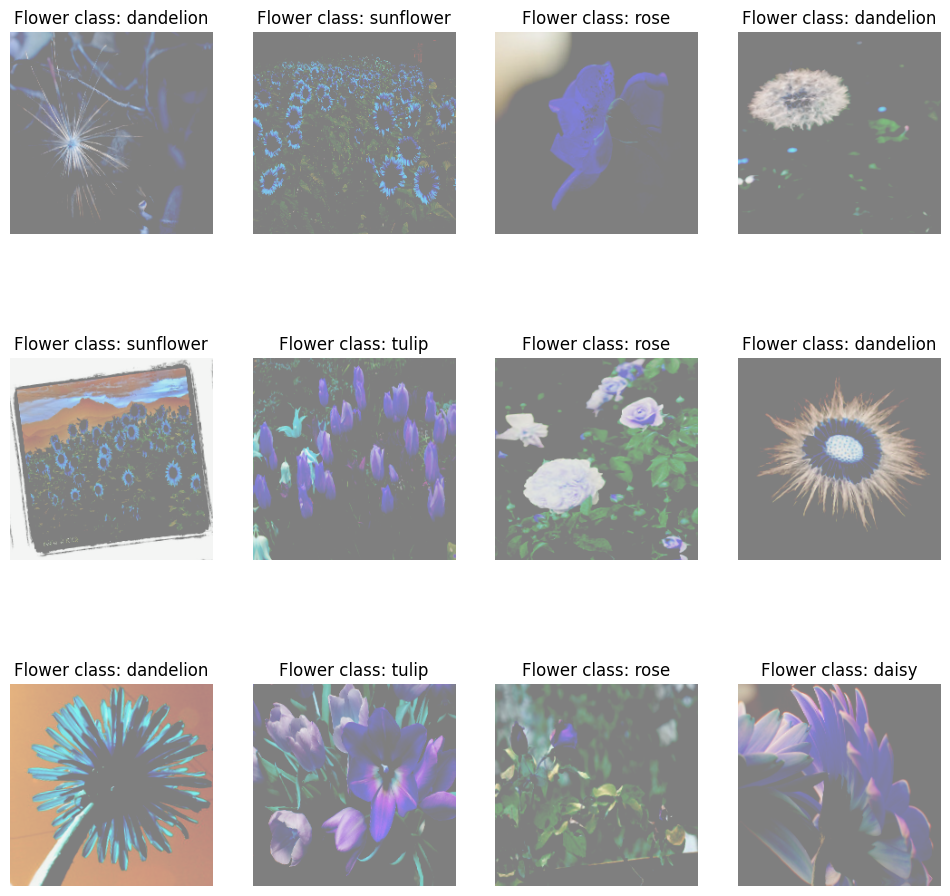

In [24]:
plt.figure(figsize=(12, 12))
for index in range(12):
    plt.subplot(3, 4, index + 1)
    plt.imshow(np.clip((X_train_aug[index] + 1) / 2,0,1))
    plt.title(f"Flower class: {train_y["Label"].iloc[index]}")
    plt.axis("off")

plt.show()

### Using a pretrained Xception from Keras.applications

In [28]:
# customize Xception model layers
def build_model_layers():
    base_model = tf.keras.applications.xception.Xception(weights="imagenet",
                                                        include_top=False)
    #  freeze the weights of pretrained layers as recommended
    for layer in base_model.layers:
        layer.trainable = False
        
    x = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
    
    # Lets try leaky Relu as activation function initilized using he_normal
    leaky_relu = tf.keras.layers.LeakyReLU(alpha=0.2)
    
    # use softmax activation
    output = tf.keras.layers.Dense(num_classes, 
                                   activation="softmax",
                                    kernel_initializer="he_normal")(x)
    model = tf.keras.Model(inputs=base_model.input, outputs=output)

    return model


# train the model 
def train_model(optimizer, lr_scheduler=None, epochs=10):
    model = build_model_layers()
    
    
    # categorical for classes and validate using accuracy
    model.compile(loss="categorical_crossentropy", optimizer=optimizer,
                  metrics=["accuracy"],) 
    
    # add an early stopping callback if no progress in validation set after 2 epochs
    early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=2)
    
    
    # training on augmented images and applied the lr_scheduler
    if lr_scheduler is not None:
        model.fit(X_train_aug, train_set_y_le, 
                validation_data=(valid_X, valid_set_y_le),
                callbacks=[early_stopping_cb, lr_scheduler], # apply  early stop
                epochs=epochs) # for only 6 epochs
    else:  
        model.fit(X_train_aug, train_set_y_le, 
                validation_data=(valid_X, valid_set_y_le),
                callbacks=[early_stopping_cb], # ealry stopping 
                epochs=epochs) # for only 10 epochs
    
    try: 
        model.save("../trained-models/tensor-Xception-best-accuracy.keras")
        model = tf.keras.models.load_model("../trained-models/tensor-Xception-best-accuracy.keras")
    except:
        pass
    return model
    

#### Learning rate scheduling and optimizer

In [29]:
# # Try a performance schedule multiply lr with 0.5 after 3 epochs
# lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=3)
# optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)

# # try power scheduling simply by adding decay pf 0.0001
# optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, decay=1e-4)

# # Optimizer RMSprop with an performance lerrning rate scheduler
# optimizer = tf.keras.optimizers.RMSprop(learning_rate=lr_scheduler)

# Applying exponential schedule
lr_scheduler = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.01,
    decay_steps=20_000,
    decay_rate=0.1,
    staircase=False  # steps set to false
)
optimizer = tf.keras.optimizers.SGD(learning_rate=lr_scheduler)

In [30]:
model = train_model(optimizer,  epochs=10) 

102/102 ━━━━━━━━━━━━━━━━━━━━ 1095s 11s/step - accuracy: 0.4818 - loss: 1.3463 - val_accuracy: 0.7515 - val_loss: 0.8346
Epoch 2/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 861s 8s/step - accuracy: 0.7266 - loss: 0.8487 - val_accuracy: 0.7500 - val_loss: 0.7101
Epoch 3/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 975s 10s/step - accuracy: 0.7636 - loss: 0.7290 - val_accuracy: 0.7778 - val_loss: 0.6395
Epoch 4/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 962s 9s/step - accuracy: 0.7890 - loss: 0.6565 - val_accuracy: 0.7963 - val_loss: 0.6016
Epoch 5/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 977s 9s/step - accuracy: 0.7992 - loss: 0.6107 - val_accuracy: 0.7994 - val_loss: 0.5719
Epoch 6/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 1019s 10s/step - accuracy: 0.8081 - loss: 0.5940 - val_accuracy: 0.8071 - val_loss: 0.5500
Epoch 7/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 956s 9s/step - accuracy: 0.8056 - loss: 0.5858 - val_accuracy: 0.7978 - val_loss: 0.5486
Epoch 8/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 931s 9s/step - accuracy: 0.8160 - loss: 0.5551 - val_accuracy: 

The best parametersfor training is SGD optimizer with an exponential scheduler for learning rate and activation function is regularization and initial kernel activation is he_normal

### Validation and predictions

In [31]:
def get_predictions(model, data_X):
    predictions = model.predict(data_X)  # Get model predictions
    pred_classes = np.argmax(predictions, axis=1)  #
    return pred_classes

In [32]:
from sklearn import metrics
def get_metrics(true_classes, predicted_classes):
    precision = metrics.precision_score(true_classes, predicted_classes, average='macro')
    recall = metrics.recall_score(true_classes, predicted_classes, average='macro')
    f1_score = metrics.f1_score(true_classes, predicted_classes, average='macro')

    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1_score:.4f}")

In [33]:
import seaborn as sns
def conf_matrix(true_classes, predicted_classes, class_names):
    conf_matrix = metrics.confusion_matrix(true_classes, predicted_classes)

    # Visualize confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

In [42]:
from random import randint
def visualize_predictions(model, class_names, num_samples=12, data_generator=[test_X, test_y]):
    # X and y 
    images, labels = data_generator

    # Perform prediction 
    pred = model.predict(images)

    # The index of predicted classes
    pred_classes = np.argmax(pred, axis=1)

    # Plot sample against the predicted class
    plt.figure(figsize=(12, 10))
    for i in range(num_samples):
        index = randint(0, len(images))
        plt.subplot(3, 4, i + 1)
        plt.imshow(np.clip((images[index] + 1) / 2,0,1))
        plt.title(f"Predicted class: {class_names[pred_classes[index]]}\nTrue class: {labels["Label"].iloc[index]}")
        plt.axis("off")

In [35]:
# Encode the text labels
from sklearn.preprocessing import LabelEncoder

def label_encoder(df):
    le = LabelEncoder()
    class_le = le.fit_transform(df)
    classes = le.classes_
    return class_le, classes

In [36]:
# load the saved model
model = tf.keras.models.load_model("../trained-models/tensor-Xception-best-accuracy.keras")

In [37]:
y_test = valid_y["Label"]
valid_y_le, class_names = label_encoder(y_test)

In [38]:
# prediction of validation set
val_predictions = get_predictions(model,  valid_X)

21/21 ━━━━━━━━━━━━━━━━━━━━ 160s 7s/step


In [39]:
# Calculate metrics
get_metrics(valid_y_le, val_predictions)

Precision: 0.8066
Recall: 0.8051
F1-score: 0.8048


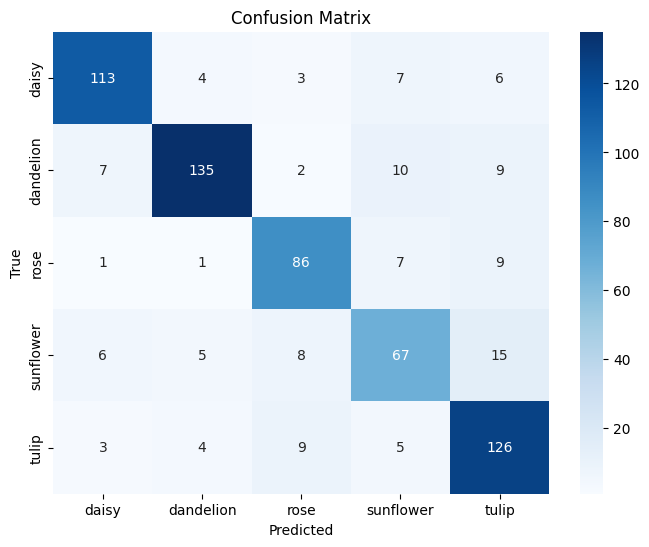

In [40]:
# get the confusion matrix
conf_matrix(valid_y_le, val_predictions, class_names)

14/14 ━━━━━━━━━━━━━━━━━━━━ 105s 8s/step


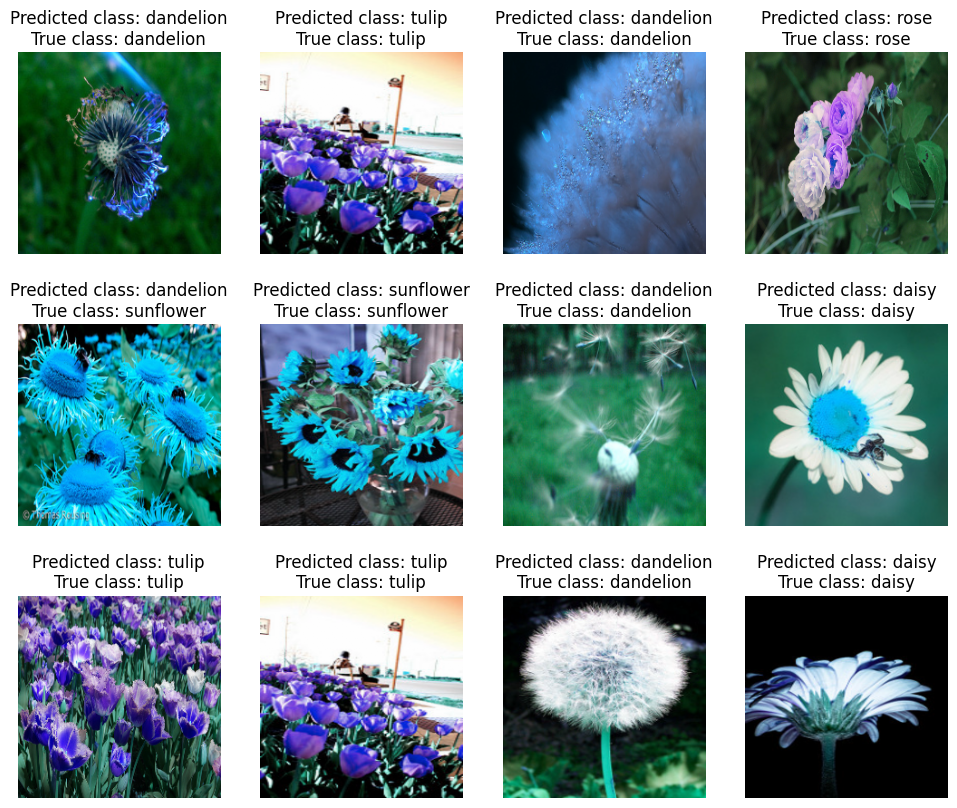

In [43]:
# Visualize predictions
visualize_predictions(model,  flower_classes)